# 基于昇思MindSpore+Orangepi AIpro的ResNet50图像分类

功能：使用基于昇思MindSpore框架开发的ResNet50实现图片分类。  
样例输入：原始图片。   
样例输出：图片分类的结果。

# 前期准备

* 基础镜像的样例目录中已包含转换后的om模型以及测试图片，如果直接运行，可跳过此步骤。如果需要重新转换模型，可以参考下面的步骤。
* **建议在Linux服务器或者虚拟机转换该模型。**
* 为了能进一步优化模型推理性能，我们需要将其转换为om模型进行使用；**转换指导详见全流程实验指导。**

# 模型推理实现

* 注意：本案例在离线推理的过程中可能会出现内存不足的问题，可以根据情况查看FAQ文档中的解决方案。

### 1. 导入三方库

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import acl
import acllite_utils as utils
import constants as const
from acllite_imageproc import AclLiteImageProc
from acllite_model import AclLiteModel
from acllite_resource import resource_list

import mindspore as ms
import mindspore.dataset as ds
from mindspore.dataset import vision

### 2. 定义acllite资源初始化与去初始化类

In [2]:
class AclLiteResource:
    """
    AclLiteResource
    """
    def __init__(self, device_id=0):
        self.device_id = device_id
        self.context = None
        self.stream = None
        self.run_mode = None
        
    def init(self):
        """
        init resource
        """
        print("init resource stage:")
        ret = acl.init()

        ret = acl.rt.set_device(self.device_id)
        utils.check_ret("acl.rt.set_device", ret)

        self.context, ret = acl.rt.create_context(self.device_id)
        utils.check_ret("acl.rt.create_context", ret)

        self.stream, ret = acl.rt.create_stream()
        utils.check_ret("acl.rt.create_stream", ret)

        self.run_mode, ret = acl.rt.get_run_mode()
        utils.check_ret("acl.rt.get_run_mode", ret)

        print("Init resource success")

    def __del__(self):
        print("acl resource release all resource")
        resource_list.destroy()
        if self.stream:
            print("acl resource release stream")
            acl.rt.destroy_stream(self.stream)

        if self.context:
            print("acl resource release context")
            acl.rt.destroy_context(self.context)

        print("Reset acl device ", self.device_id)
        acl.rt.reset_device(self.device_id)
        print("Release acl resource success")

### 3. 定义Resnet50类，包含前处理、推理等操作

In [3]:
class Resnet50(object):
    """
    class for Resnet50
    """
    def __init__(self, model_path, model_width, model_height):
        self._model_path = model_path
        self._model_width = model_width
        self._model_height = model_height
        self.device_id = 0
        self._dvpp = None
        self._model = None

    def init(self):
        """
        Initialize
        """
        # 初始化dvpp
        self._dvpp = AclLiteImageProc()

        # 加载模型
        self._model = AclLiteModel(self._model_path)
        return const.SUCCESS
    
    @utils.display_time
    # 定义数据预处理函数
    def pre_process(self, input_path):
        # 利用Cifar10Dataset接口读取测试数据
        dataset_predict = ds.Cifar10Dataset(dataset_dir=input_path, shuffle=False)
        # 对数据进行预处理操作：调整数据尺寸、归一化、标准化、调整通道顺序。
        image_test = [
            vision.Resize((32, 32)),
            vision.Rescale(1.0 / 255.0, 0.0),
            vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
            vision.HWC2CHW()
                ]
        dataset_predict = dataset_predict.map(image_test, 'image')
        # 设置推理数据的batch
        dataset_predict = dataset_predict.batch(4)

        return dataset_predict
    
    @utils.display_time
    def inference(self, input_path, dataset_predict1):
        """
        model inference
        """
        # 迭代读取数据
        resized_image = next(dataset_predict1.create_dict_iterator())
        images = resized_image["image"]
        labels = resized_image["label"]
        print("resized_image['label']: ", resized_image['label'])
        result1 = ms.Tensor(resized_image['image'])
        # 对数据进行推理
        preds = self._model.execute([result1.asnumpy(), ])
        
        return images, labels, preds


### 4. 构造主函数，串联整个代码逻辑

In [ ]:
from download import download

# 获取数据集
dataset_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-mindspore/03-ResNet50/cifar-10-batches-bin.zip"
download(dataset_url, "./datasets-cifar10-bin", kind="zip", replace=True)

# 获取模型om文件
model_url = "https://modelers.cn/coderepo/web/v1/file/MindSpore-Lab/cluoud_obs/main/media/examples/mindspore-courses/orange-pi-mindspore/03-ResNet50/resnet50.zip"
download(model_url, "./model", kind="zip", replace=True)

In [4]:
def main():

    # 给定模型路径和输入模型的图片尺寸
    MODEL_PATH = "./model/resnet50.om"
    MODEL_WIDTH = 32
    MODEL_HEIGHT = 32
    # 初始化acl资源
    acl_resource = AclLiteResource() 
    acl_resource.init()
    
    # 初始化 Resnet50 类
    resnet50 = Resnet50(MODEL_PATH, MODEL_WIDTH, MODEL_HEIGHT)  # 构造模型对象
    
    # 初始化模型类变量
    ret = resnet50.init()  
    utils.check_ret("Resnet50.init ", ret)  
    # 给定推理数据的路径
    input_path = "./datasets-cifar10-bin/cifar-10-batches-bin"

    print('===================')
    # 调用数据预处理函数，对数据进行预处理
    crop_and_paste_image = resnet50.pre_process(input_path)
    
    print("crop_and_paste_image: ", crop_and_paste_image)
    # 进行推理
    images, labels, result = resnet50.inference(input_path, crop_and_paste_image)
    pred = np.argmax(result[0], axis=1)
    print("pred: ", pred)
    
    classes = []

    with open(input_path + "/batches.meta.txt", "r") as f:
        for line in f:
            line = line.rstrip()
            if line:
                classes.append(line)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels.asnumpy()[i] else 'red'
        plt.title('predict:{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images.asnumpy()[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

### 5. 运行
运行完成后，会显示推理后的图片，如下所示。

init resource stage:
Init resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 160
Create model output dataset success
Init model resource success
crop_and_paste_image:  <mindspore.dataset.engine.datasets.BatchDataset object at 0xe7ff3e2cd9d0>
resized_image['label']:  [3 8 8 0]
pred:  [3 8 8 0]


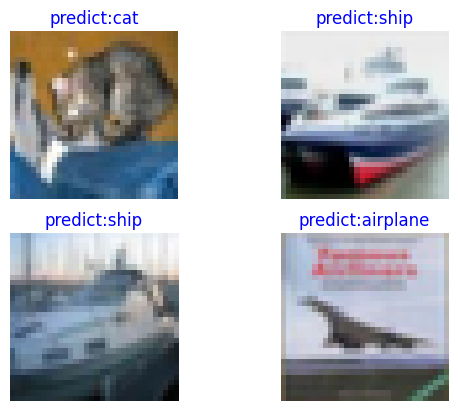

acl resource release all resource
dvpp resource release success
AclLiteModel release source success
acl resource release stream
acl resource release context
Reset acl device  0
Release acl resource success


In [5]:
main()

# 样例总结

我们来回顾一下以上代码，可以包括以下几个步骤：

1. 初始化acl资源：在调用acl相关资源时，必须先初始化AscendCL，否则可能会导致后续系统内部资源初始化出错。  
2. 推理：利用AclLiteModel.execute接口对图片进行推理。  
3. 对推理结果进行后处理：包括两个步骤，即转换像素值值域以及将图片缩放到原图大小。  
4. 可视化图片：利用plt将结果画出。